# (함수) DataFrame으로 불러오는 함수

In [25]:
import pandas as pd

In [26]:
def openDataFrame(path):
    return pd.read_csv(path, on_bad_lines='skip', encoding = "ISO-8859-1")

# 0. 원본 데이터 :  Wine Quality Prediction Analysis - Classification

In [27]:
path_wine = './winequality.csv'

In [28]:
df_wine = openDataFrame(path_wine)
df_wine

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


# 1. 전처리기(나만의 변환기들)

In [29]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

## 1.1 변환기: Type 이진화

In [30]:
class TypeBinaryConverter(BaseEstimator, TransformerMixin):
    def __init__(self, name='type'):
        self.name = name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.name] = (X[self.name] == 'white').astype(int)
        return X

## 1.2 변환기: quality 3->4, 9->8 변환

In [31]:
class MergeQuality(BaseEstimator, TransformerMixin):
    def __init__(self, name='quality'):
        self.name = name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.name] = X[self.name].replace({3:4, 9:8})
        return X

## 1.3 변환기: quality 4, ... ,8 이진그룹화 변환

In [32]:
class QualityGroups(BaseEstimator, TransformerMixin):
    def __init__(self, listGroups=['quality_4', 'quality_5', 'quality_6', 'quality_7', 'quality_8']):
        self.listGroups = listGroups
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for i, name in enumerate(self.listGroups):
            X[name] = (X['quality']==i+4).astype(int)
        return X

## 1.4 변환기: 특성들의 극단치 모두 제거

In [33]:
class DropOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, scope=5):
        self.scope = scope
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        myList = []
        for name in X.columns:
            if name not in ['type', 'quality']:
                Q1 = X[[name]].quantile(0.25)
                Q3 = X[[name]].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.scope * IQR
                upper_bound = Q3 + self.scope * IQR

                # 극단치가 있는 열과 행을 찾음
                outlier_cols = np.where((X[[name]] < lower_bound) | (X[[name]] > upper_bound))[1]
                outlier_rows = np.where((X[[name]] < lower_bound) | (X[[name]] > upper_bound))[0]

                # 극단치가 있는 행의 인덱스를 반환
                outlier_indices = pd.Series(outlier_rows).unique()    
                myList += list(outlier_indices)
        newDf = X.copy().drop(myList, axis=0)
        return newDf

## 1.5 변환기: log_scaler

In [34]:
import numpy as np

class LogScaler(BaseEstimator, TransformerMixin):
    def __init__(self, listNames=['chlorides', 'residual sugar']):
        self.listNames = listNames
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for name in self.listNames:
            X[name] = [np.log(x+1) for x in list(X[name])]
        return X

In [35]:
# logScaler = LogScaler()
# logScaler.transform(df_wine.iloc[:, 1:])

## 1.6 KNN이용한 결측치 채우기

In [36]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

## 1.7 DataFrame 포맷으로 되돌리기

In [37]:
class FormatDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, column_names=['type','fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality','quality_4','quality_5','quality_6','quality_7','quality_8']):
        self.column_names = column_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.column_names)

# 2. 전처리 파이프라인 구성

## 2.1 Pipeline을 이용한 전처리 작동 코드

In [38]:
from sklearn.pipeline import Pipeline

preproc_pipeline = Pipeline([
    ('binary_type', TypeBinaryConverter()), # type변수를 0,1 binary화
    ('drop_outliers', DropOutliers(scope=5)), # 이상치 제거
    ('merge_quality', MergeQuality()), # quality변수 3->4, 9->8 변환
    ('quality_groups', QualityGroups()), # quality변수 one-hot encode(binary 모델 구축을 위한)
    ('log_scaler', LogScaler()), # log정규화
    ('knn_imputer', KNNImputer(n_neighbors=2, weights="uniform")), # 결측치 KNN 메꾸기
    ('format_dataframe', FormatDataFrame()) # 데이터프레임으로 재정의
])

# 각단계 전처리를 끄고 싶으면(하지 않고 싶으면), 각 라인을 주석처리하면 됨.
# 예를 들어, 두 번째 줄 ('drop_outliers', DropOutliers(scope=5))을 주석처리하면 극단치 제거가 되지 않음.

In [39]:
# 다음과 같이 일반적인 estimator처럼 fit_transform() 메소드로 전처리 가능
df_preproc = preproc_pipeline.fit_transform(df_wine.copy())

# 3. 전처리된 데이터프레임으로 작업하기

In [40]:
# 전처리된 데이터프레임 호출
df_preproc

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_4,quality_5,quality_6,quality_7,quality_8
0,1.0,7.0,0.270,0.36,3.077312,0.044017,45.0,170.0,1.00100,3.00,0.45,8.8,6.0,0.0,0.0,1.0,0.0,0.0
1,1.0,6.3,0.300,0.34,0.955511,0.047837,14.0,132.0,0.99400,3.30,0.49,9.5,6.0,0.0,0.0,1.0,0.0,0.0
2,1.0,8.1,0.280,0.40,2.066863,0.048790,30.0,97.0,0.99510,3.26,0.44,10.1,6.0,0.0,0.0,1.0,0.0,0.0
3,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,0.0,0.0,1.0,0.0,0.0
4,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6414,0.0,6.2,0.600,0.08,1.098612,0.086178,32.0,44.0,0.99490,3.45,0.58,10.5,5.0,0.0,1.0,0.0,0.0,0.0
6415,0.0,5.9,0.550,0.10,1.163151,0.060154,39.0,51.0,0.99512,3.52,0.93,11.2,6.0,0.0,0.0,1.0,0.0,0.0
6416,0.0,6.3,0.510,0.13,1.193922,0.073250,29.0,40.0,0.99574,3.42,0.75,11.0,6.0,0.0,0.0,1.0,0.0,0.0
6417,0.0,5.9,0.645,0.12,1.098612,0.072321,32.0,44.0,0.99547,3.57,0.71,10.2,5.0,0.0,1.0,0.0,0.0,0.0


In [41]:
# 이렇게 하면 X
X = df_preproc.iloc[:, :-6]
X

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,7.0,0.270,0.36,3.077312,0.044017,45.0,170.0,1.00100,3.00,0.45,8.8
1,1.0,6.3,0.300,0.34,0.955511,0.047837,14.0,132.0,0.99400,3.30,0.49,9.5
2,1.0,8.1,0.280,0.40,2.066863,0.048790,30.0,97.0,0.99510,3.26,0.44,10.1
3,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9
4,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9
...,...,...,...,...,...,...,...,...,...,...,...,...
6414,0.0,6.2,0.600,0.08,1.098612,0.086178,32.0,44.0,0.99490,3.45,0.58,10.5
6415,0.0,5.9,0.550,0.10,1.163151,0.060154,39.0,51.0,0.99512,3.52,0.93,11.2
6416,0.0,6.3,0.510,0.13,1.193922,0.073250,29.0,40.0,0.99574,3.42,0.75,11.0
6417,0.0,5.9,0.645,0.12,1.098612,0.072321,32.0,44.0,0.99547,3.57,0.71,10.2


In [42]:
# 이렇게 하면 quality_6의 목적변수
# y_6 = df_preproc[['quality_6']]
for i in range(4, 9):
    column_name = 'quality_' + str(i)
    globals()['y_'+str(i)] = df_preproc[[column_name]]

# 4. XGBClassifier

## 4.1 training-validation-test seperation

In [43]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# # 데이터셋을 트레이닝 셋과 임시 셋으로 60:40 비율로 나눔
# X_train, X_tmp, y_4_train, y_4_tmp = train_test_split(X, y_4, test_size=0.4, random_state=100)
# # oversampling(ros), undersampling(rus)
# ros = SMOTE(k_neighbors=4)
# X_train_ros, y_4_train_ros = ros.fit_resample(X_train, y_4_train)
# rus = RandomUnderSampler(random_state=100)
# X_train_rus, y_4_train_rus = rus.fit_resample(X_train, y_4_train)
# # 임시 셋을 밸리데이션 셋과 테스트 셋으로 50:50 비율로 나눔
# X_val, X_test, y_4_val, y_4_test = train_test_split(X_tmp, y_4_tmp, test_size=0.5, random_state=100)

for i in range(4, 9):
    column_name = 'quality_' + str(i)
    globals()['y_'+str(i)] = df_preproc[[column_name]]
    # 데이터셋을 트레이닝 셋과 임시 셋으로 60:40 비율로 나눔
    globals()['X_'+str(i)+'_train'], globals()['X_'+str(i)+'_tmp'], globals()['y_'+str(i)+'_train'], globals()['y_'+str(i)+'_tmp'] = train_test_split(X, globals()['y_'+str(i)], test_size=0.4, random_state=100)
    # oversampling(ros), undersampling(rus)
    ros = SMOTE(k_neighbors=4)
    globals()['X_'+str(i)+'_train_ros'], globals()['y_'+str(i)+'_train_ros'] = ros.fit_resample(globals()['X_'+str(i)+'_train'], globals()['y_'+str(i)+'_train'])
    rus = RandomUnderSampler(random_state=100)
    globals()['X_'+str(i)+'_train_rus'], globals()['y_'+str(i)+'_train_rus'] = rus.fit_resample(globals()['X_'+str(i)+'_train'], globals()['y_'+str(i)+'_train'])
    # 임시 셋을 밸리데이션 셋과 테스트 셋으로 50:50 비율로 나눔
    globals()['X_'+str(i)+'_val'], globals()['X_'+str(i)+'_test'], globals()['y_'+str(i)+'_val'], globals()['y_'+str(i)+'_test'] = train_test_split(globals()['X_'+str(i)+'_tmp'], globals()['y_'+str(i)+'_tmp'], test_size=0.5, random_state=100)

## 4.2 randomizedSearch

In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer

In [44]:
for i in range(4, 9):
    # 로지스틱 회귀(멀티클래스) 모델 정의
    xgb_orign = XGBClassifier()
    xgb_ros = XGBClassifier()
    xgb_rus = XGBClassifier()

    # 탐색할 파라미터 그리드 정의
    param_distributions = {
        'max_depth': [3, 5, 7, 9, 11, 13],
        'learning_rate': np.logspace(-3, 0, 100),
        'n_estimators': [50, 100, 200, 300, 400],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': np.logspace(-3, 3, 100),
        'reg_lambda': np.logspace(-3, 3, 100)
    }

    # 그리드 서치 객체 생성
    ran_search_orign = RandomizedSearchCV(estimator=xgb_orign, param_distributions=param_distributions, n_iter=100, cv=5, scoring='f1', n_jobs=-1)
    ran_search_ros = RandomizedSearchCV(estimator=xgb_ros, param_distributions=param_distributions, n_iter=100, cv=5, scoring='f1', n_jobs=-1)
    ran_search_rus = RandomizedSearchCV(estimator=xgb_rus, param_distributions=param_distributions, n_iter=100, cv=5, scoring='f1', n_jobs=-1)

    # 그리드 서치 수행
    ran_search_orign.fit(globals()['X_'+str(i)+'_train'], globals()['y_'+str(i)+'_train'])
    ran_search_ros.fit(globals()['X_'+str(i)+'_train_ros'], globals()['y_'+str(i)+'_train_ros'])
    ran_search_rus.fit(globals()['X_'+str(i)+'_train_rus'], globals()['y_'+str(i)+'_train_rus'])

    # 최적 파라미터와 점수 출력
    print('y_' + str(i))
    print('-------------------------------------------------------------------------------------------------------------------')
    print("orign data result: ", ran_search_orign.best_params_)
    print("orign data result: ", ran_search_orign.best_score_)
    print('-------------------------------------------------------------------------------------------------------------------')
    print("ros data result: ", ran_search_ros.best_params_)
    print("ros data result: ", ran_search_ros.best_score_)
    print('-------------------------------------------------------------------------------------------------------------------')
    print("rus data result: ", ran_search_rus.best_params_)
    print("rus data result: ", ran_search_rus.best_score_)
    print('-------------------------------------------------------------------------------------------------------------------')

y_4
-------------------------------------------------------------------------------------------------------------------
orign data result:  {'subsample': 0.8, 'reg_lambda': 0.008111308307896872, 'reg_alpha': 0.03274549162877728, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.572236765935022, 'gamma': 0.3, 'colsample_bytree': 0.8}
orign data result:  0.2156681000159261
-------------------------------------------------------------------------------------------------------------------
ros data result:  {'subsample': 0.7, 'reg_lambda': 0.0023101297000831605, 'reg_alpha': 0.1747528400007685, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.049770235643321115, 'gamma': 0.3, 'colsample_bytree': 0.9}
ros data result:  0.9822475526917218
-------------------------------------------------------------------------------------------------------------------
rus data result:  {'subsample': 0.8, 'reg_lambda': 17.47528400007683, 'reg_alpha': 0.0026560877829466868, 'n_estimators': 100, 'ma

## 4.3 모형

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [46]:
# 평가지표 함수
def evaluate_model(y_true, y_pred_list, model_names=None):
    """
    다중의 예측 결과에 대해 평가 지표를 계산하고 ROC curve를 출력하는 함수
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        실제 타깃 값
    y_pred_list : list of array-like of shape (n_samples,)
        예측된 타깃 값들
    model_names : list of str, optional (default=None)
        예측된 타깃 값들에 대응하는 모델 이름 리스트
        
    Returns
    -------
    None
    """
    # 평가지표 계산
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
    scores = []
    for i, y_pred in enumerate(y_pred_list):
        cm_i = confusion_matrix(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score = auc(fpr, tpr)
        scores.append([acc, precision, recall, f1, auc_score])
    
    # 모델 이름 리스트
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(y_pred_list))]

    # 평가지표 출력
    header_format = "{:^15s} | " + " | ".join(["{:^10s}"] * len(metrics))
    row_format = "{:^15s} | " + " | ".join(["{:^10.4f}"] * len(metrics))
    print(header_format.format("", *metrics))
    print('-' * 80)
    for i, score in enumerate(scores):
        print(row_format.format(model_names[i], *score))
    print('-' * 80)

    # ROC curve 출력
    plt.figure(figsize=(5, 5))
    for i, y_pred in enumerate(y_pred_list):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_names[i]} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def feature_importance(X, y, models, model_names):
    fig, ax = plt.subplots(1, len(models), figsize=(35, 5)) # 여러 모델의 그래프를 가로로 나열하기 위해 subplot 사용
    for i, model in enumerate(models):
        # feature importance 계산
        importance = model.feature_importances_
        # 절대값 취해서 정규화
        importance = np.abs(importance) / np.sum(np.abs(importance))
        # feature importance 그래프 출력
        sorted_idx = np.argsort(importance)# 내림차순으로 정렬된 index 반환
        ax[i].barh(range(len(X.columns)), importance[sorted_idx])
        ax[i].set_yticks(range(len(X.columns)))
        ax[i].set_yticklabels(X.columns[sorted_idx])
        ax[i].set_title(f'Feature Importance of {model_names[i]}')

        # feature importance 목록 출력
        importance_df = pd.DataFrame({'feature': X.columns, 'importance': importance})
        importance_df = importance_df.sort_values('importance', ascending=False)
        print(f'{model_names[i]} Feature Importance')
        print(importance_df)
    plt.show()

### 4.3.1 y_4

In [25]:
# y_4
# -------------------------------------------------------------------------------------------------------------------
# orign data result:  {'subsample': 0.8, 'reg_lambda': 0.008111308307896872, 'reg_alpha': 0.03274549162877728, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.572236765935022, 'gamma': 0.3, 'colsample_bytree': 0.8}
# orign data result:  0.2156681000159261
# -------------------------------------------------------------------------------------------------------------------
# ros data result:  {'subsample': 0.7, 'reg_lambda': 0.0023101297000831605, 'reg_alpha': 0.1747528400007685, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.049770235643321115, 'gamma': 0.3, 'colsample_bytree': 0.9}
# ros data result:  0.9822475526917218
# -------------------------------------------------------------------------------------------------------------------
# rus data result:  {'subsample': 0.8, 'reg_lambda': 17.47528400007683, 'reg_alpha': 0.0026560877829466868, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.21544346900318845, 'gamma': 0.1, 'colsample_bytree': 0.8}
# rus data result:  0.7775223499361431
# -------------------------------------------------------------------------------------------------------------------

In [48]:
# 하이퍼파라미터 설정
model_xgb_orign_class_4 = XGBClassifier(subsample=0.8, reg_lambda=0.008111308307896872, reg_alpha=0.03274549162877728, n_estimators=50, max_depth=3, learning_rate=0.572236765935022, gamma=0.3, colsample_bytree=0.8)
model_xgb_ros_class_4 = XGBClassifier(subsample=0.7, reg_lambda=0.0023101297000831605, reg_alpha=0.1747528400007685, n_estimators=400, max_depth=7, learning_rate=0.049770235643321115, gamma=0.3, colsample_bytree=0.9)
model_xgb_rus_class_4 = XGBClassifier(subsample=0.8, reg_lambda=17.47528400007683, reg_alpha=0.0026560877829466868, n_estimators=100, max_depth=9, learning_rate=0.21544346900318845, gamma=0.1, colsample_bytree=0.8)

# 모델 학습
model_xgb_orign_class_4.fit(X_4_train, y_4_train)
model_xgb_ros_class_4.fit(X_4_train_ros, y_4_train_ros)
model_xgb_rus_class_4.fit(X_4_train_rus, y_4_train_rus)

# 모델 예측
xgb_orign_class_4_pred = model_xgb_orign_class_4.predict(X_4_val)
xgb_ros_class_4_pred = model_xgb_ros_class_4.predict(X_4_val)
xgb_rus_class_4_pred = model_xgb_rus_class_4.predict(X_4_val)
print(xgb_orign_class_4_pred)
print(xgb_ros_class_4_pred)
print(xgb_rus_class_4_pred)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
   original     |   0.9579   |   0.3333   |   0.1020   |   0.1562   |   0.5470  
  oversample    |   0.9533   |   0.3429   |   0.2449   |   0.2857   |   0.6131  
  undersample   |   0.7399   |   0.1096   |   0.8163   |   0.1932   |   0.7766  
--------------------------------------------------------------------------------


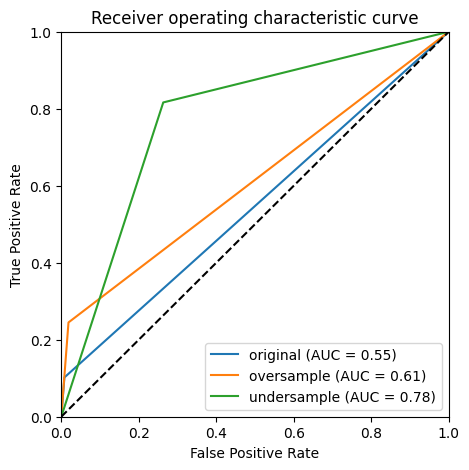

In [49]:
# 평가지표
evaluate_model(y_4_val, [xgb_orign_class_4_pred, xgb_ros_class_4_pred, xgb_rus_class_4_pred], ['original', 'oversample', 'undersample'])

Confusion matrix, without normalization
[[1225   10]
 [  44    5]]


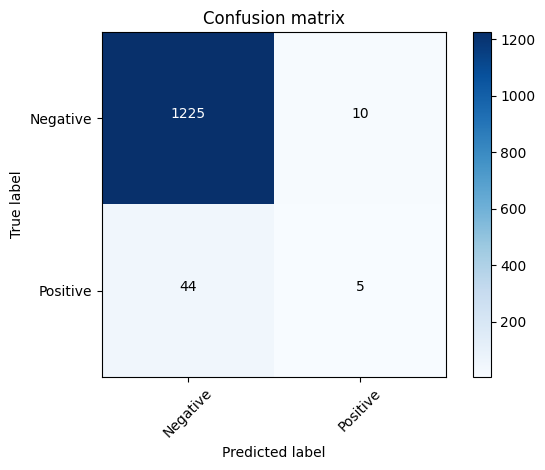

Confusion matrix, without normalization
[[1212   23]
 [  37   12]]


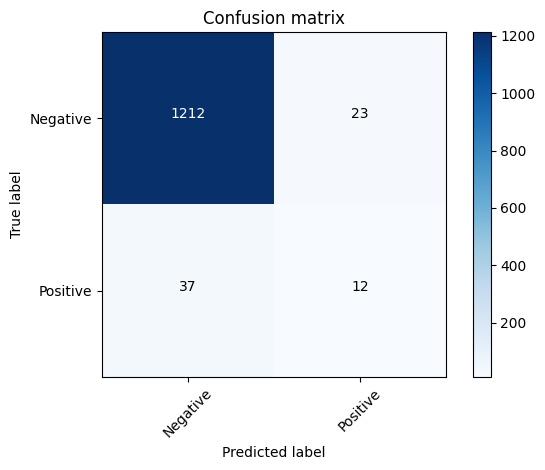

Confusion matrix, without normalization
[[910 325]
 [  9  40]]


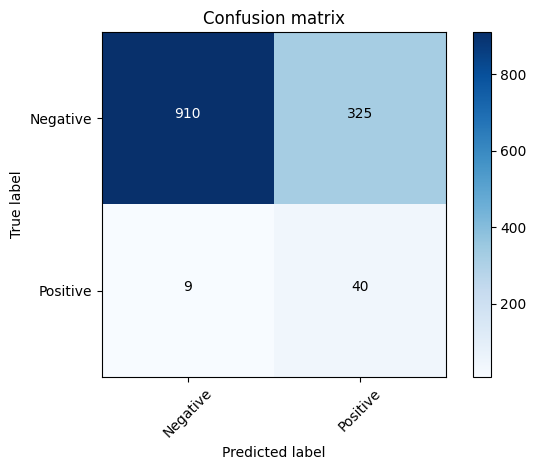

In [50]:
# 클래스의 이름을 정의
class_names = ['Negative', 'Positive']
cm_4_orign = confusion_matrix(y_4_val, xgb_orign_class_4_pred)
cm_4_ros = confusion_matrix(y_4_val, xgb_ros_class_4_pred)
cm_4_rus = confusion_matrix(y_4_val, xgb_rus_class_4_pred)

# 혼동행렬 그래프 출력
plt.figure()
plot_confusion_matrix(cm_4_orign, classes=class_names, title='Confusion matrix')
plt.show()

plt.figure()
plot_confusion_matrix(cm_4_ros, classes=class_names, title='Confusion matrix')
plt.show()

plt.figure()
plot_confusion_matrix(cm_4_rus, classes=class_names, title='Confusion matrix')
plt.show()

original Feature Importance
                 feature  importance
0                   type    0.108351
6    free sulfur dioxide    0.104551
10             sulphates    0.097131
8                density    0.088549
5              chlorides    0.087945
9                     pH    0.077315
11               alcohol    0.074932
1          fixed acidity    0.074672
2       volatile acidity    0.074586
3            citric acid    0.071687
4         residual sugar    0.070237
7   total sulfur dioxide    0.070044
oversample Feature Importance
                 feature  importance
0                   type    0.172632
6    free sulfur dioxide    0.135286
10             sulphates    0.094795
2       volatile acidity    0.092899
7   total sulfur dioxide    0.088355
11               alcohol    0.078377
4         residual sugar    0.072465
5              chlorides    0.063577
1          fixed acidity    0.056522
9                     pH    0.053364
8                density    0.052814
3            citr

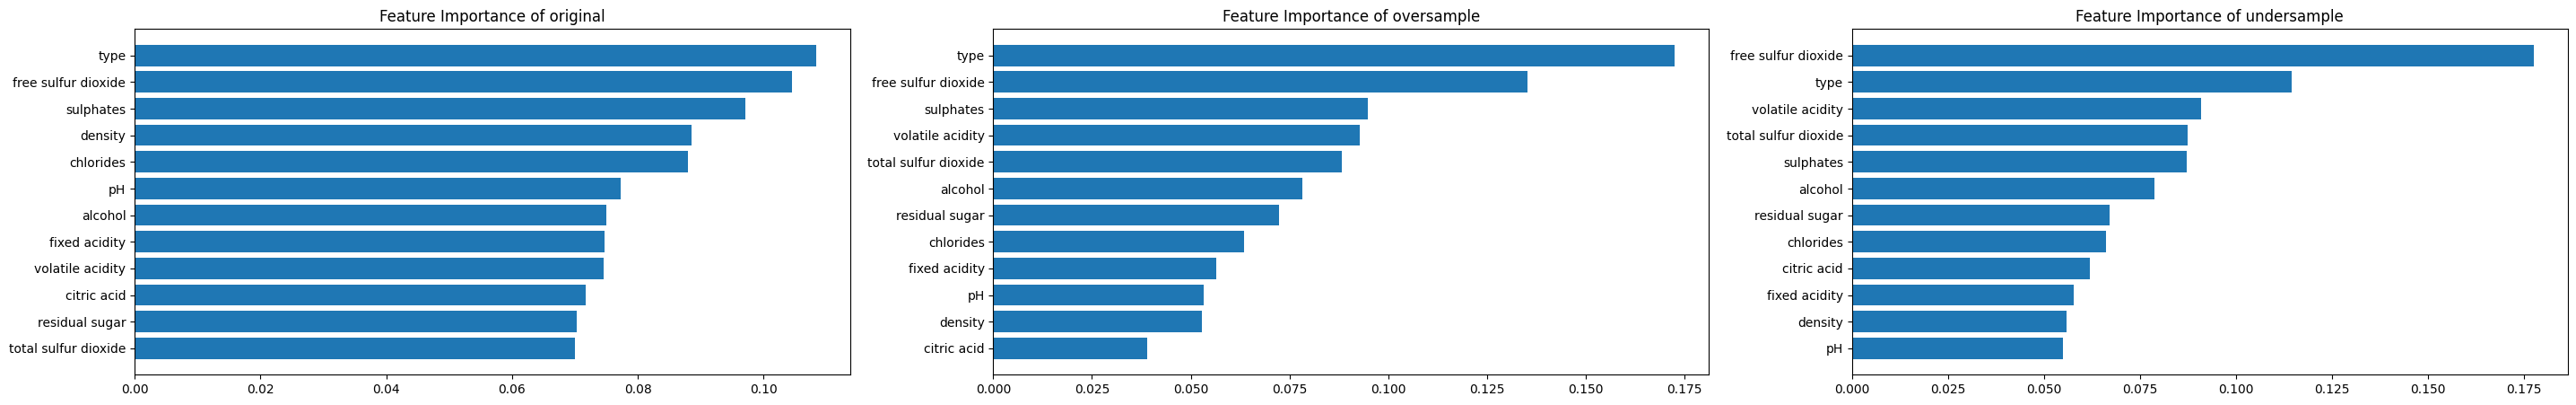

In [53]:
# feature importance
feature_importance(X_4_val, y_4_val, [model_xgb_orign_class_4, model_xgb_ros_class_4, model_xgb_rus_class_4], ['original', 'oversample', 'undersample'])

### 4.3.1 y_5

In [30]:
# y_5
# -------------------------------------------------------------------------------------------------------------------
# orign data result:  {'subsample': 0.9, 'reg_lambda': 0.23101297000831603, 'reg_alpha': 0.014174741629268055, 'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.011497569953977356, 'gamma': 0.2, 'colsample_bytree': 0.9}
# orign data result:  0.6539537829681064
# -------------------------------------------------------------------------------------------------------------------
# ros data result:  {'subsample': 0.7, 'reg_lambda': 10.0, 'reg_alpha': 0.2009233002565048, 'n_estimators': 400, 'max_depth': 13, 'learning_rate': 0.1519911082952933, 'gamma': 0.1, 'colsample_bytree': 0.7}
# ros data result:  0.8358452551349114
# -------------------------------------------------------------------------------------------------------------------
# rus data result:  {'subsample': 0.6, 'reg_lambda': 0.05722367659350217, 'reg_alpha': 0.02848035868435802, 'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.014174741629268055, 'gamma': 0.5, 'colsample_bytree': 1.0}
# rus data result:  0.7723851441017999
# -------------------------------------------------------------------------------------------------------------------

In [54]:
# 하이퍼파라미터 설정
model_xgb_orign_class_5 = XGBClassifier(subsample=0.9, reg_lambda=0.23101297000831603, reg_alpha=0.014174741629268055, n_estimators=200, max_depth=11, learning_rate=0.011497569953977356, gamma=0.2, colsample_bytree=0.9)
model_xgb_ros_class_5 = XGBClassifier(subsample=0.7, reg_lambda=10.0, reg_alpha=0.2009233002565048, n_estimators=400, max_depth=13, learning_rate=0.1519911082952933, gamma=0.1, colsample_bytree=0.7)
model_xgb_rus_class_5 = XGBClassifier(subsample=0.6, reg_lambda=0.05722367659350217, reg_alpha=0.02848035868435802, n_estimators=300, max_depth=11, learning_rate=0.014174741629268055, gamma=0.5, colsample_bytree=1.0)

# 모델 학습
model_xgb_orign_class_5.fit(X_5_train, y_5_train)
model_xgb_ros_class_5.fit(X_5_train_ros, y_5_train_ros)
model_xgb_rus_class_5.fit(X_5_train_rus, y_5_train_rus)

# 모델 예측
xgb_orign_class_5_pred = model_xgb_orign_class_5.predict(X_5_val)
xgb_ros_class_5_pred = model_xgb_ros_class_5.predict(X_5_val)
xgb_rus_class_5_pred = model_xgb_rus_class_5.predict(X_5_val)
print(xgb_orign_class_5_pred)
print(xgb_ros_class_5_pred)
print(xgb_rus_class_5_pred)

[0 0 1 ... 0 0 1]
[0 1 1 ... 0 0 1]
[0 1 1 ... 0 0 1]


                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
   original     |   0.8185   |   0.7243   |   0.6717   |   0.6970   |   0.7782  
  oversample    |   0.7975   |   0.6667   |   0.6967   |   0.6814   |   0.7698  
  undersample   |   0.7656   |   0.5891   |   0.8120   |   0.6828   |   0.7783  
--------------------------------------------------------------------------------


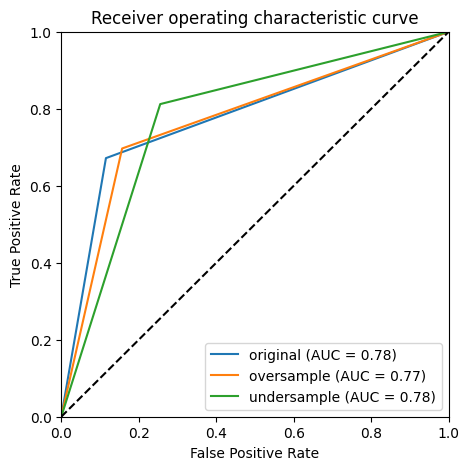

In [55]:
# 평가지표
evaluate_model(y_5_val, [xgb_orign_class_5_pred, xgb_ros_class_5_pred, xgb_rus_class_5_pred], ['original', 'oversample', 'undersample'])

Confusion matrix, without normalization
[[783 102]
 [131 268]]


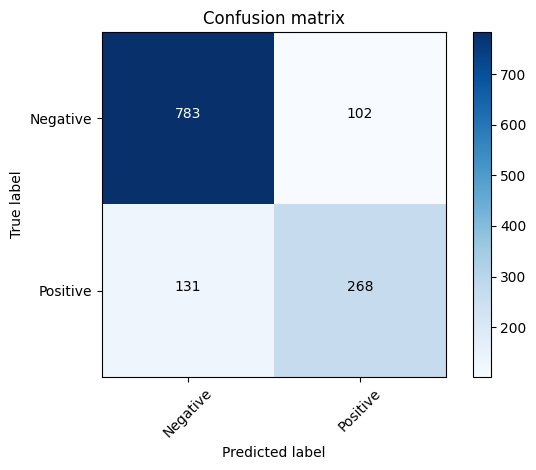

Confusion matrix, without normalization
[[746 139]
 [121 278]]


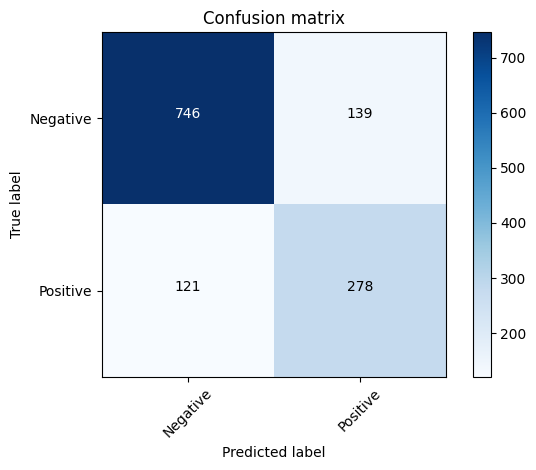

Confusion matrix, without normalization
[[659 226]
 [ 75 324]]


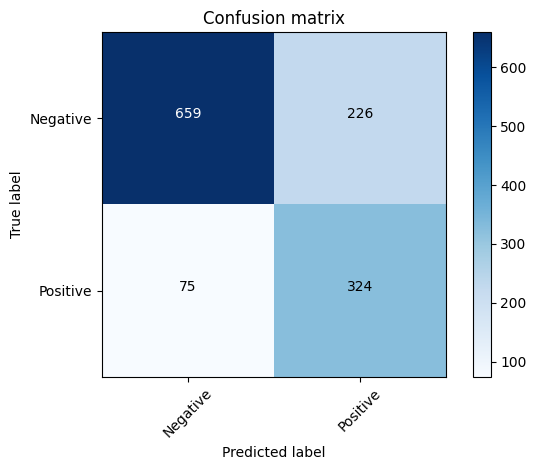

In [56]:
# 클래스의 이름을 정의
class_names = ['Negative', 'Positive']
cm_5_orign = confusion_matrix(y_5_val, xgb_orign_class_5_pred)
cm_5_ros = confusion_matrix(y_5_val, xgb_ros_class_5_pred)
cm_5_rus = confusion_matrix(y_5_val, xgb_rus_class_5_pred)

# 혼동행렬 그래프 출력
plt.figure()
plot_confusion_matrix(cm_5_orign, classes=class_names, title='Confusion matrix')
plt.show()

plt.figure()
plot_confusion_matrix(cm_5_ros, classes=class_names, title='Confusion matrix')
plt.show()

plt.figure()
plot_confusion_matrix(cm_5_rus, classes=class_names, title='Confusion matrix')
plt.show()

original Feature Importance
                 feature  importance
11               alcohol    0.249424
2       volatile acidity    0.109274
8                density    0.072201
4         residual sugar    0.067379
10             sulphates    0.064750
3            citric acid    0.064268
6    free sulfur dioxide    0.063308
1          fixed acidity    0.062985
7   total sulfur dioxide    0.062514
5              chlorides    0.062050
0                   type    0.061751
9                     pH    0.060096
oversample Feature Importance
                 feature  importance
11               alcohol    0.176532
0                   type    0.175647
2       volatile acidity    0.084286
8                density    0.073324
10             sulphates    0.066931
5              chlorides    0.064937
1          fixed acidity    0.064277
4         residual sugar    0.061908
3            citric acid    0.061678
7   total sulfur dioxide    0.060017
9                     pH    0.058088
6    free sulfur 

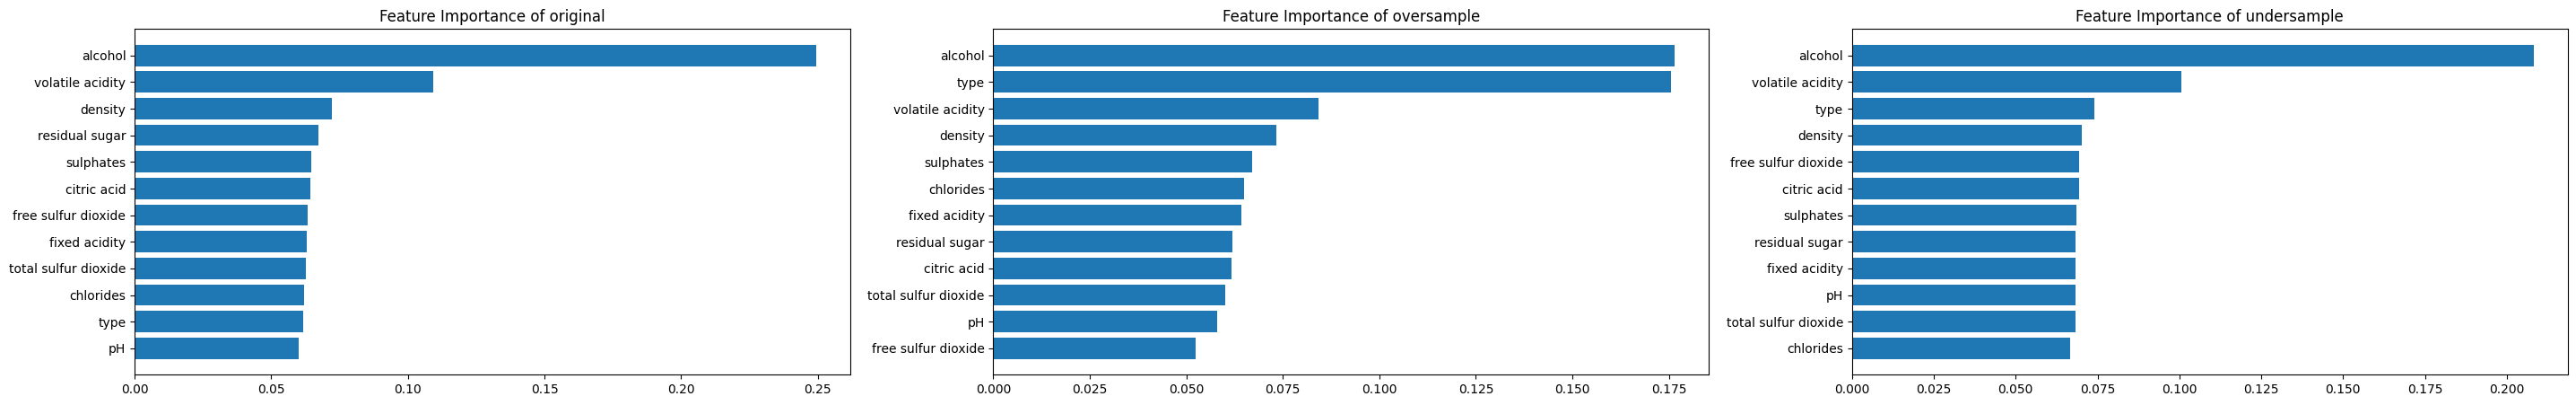

In [57]:
# feature importance
feature_importance(X_5_val, y_5_val, [model_xgb_orign_class_5, model_xgb_ros_class_5, model_xgb_rus_class_5], ['original', 'oversample', 'undersample'])

### 4.3.1 y_6

In [35]:
# y_6
# -------------------------------------------------------------------------------------------------------------------
# orign data result:  {'subsample': 1.0, 'reg_lambda': 0.06579332246575682, 'reg_alpha': 0.08697490026177834, 'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.08111308307896872, 'gamma': 0.5, 'colsample_bytree': 0.9}
# orign data result:  0.6123341530609228
# -------------------------------------------------------------------------------------------------------------------
# ros data result:  {'subsample': 0.9, 'reg_lambda': 0.004037017258596553, 'reg_alpha': 0.23101297000831603, 'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.007054802310718645, 'gamma': 0, 'colsample_bytree': 0.6}
# ros data result:  0.712850656336428
# -------------------------------------------------------------------------------------------------------------------
# rus data result:  {'subsample': 1.0, 'reg_lambda': 0.003511191734215131, 'reg_alpha': 0.01873817422860384, 'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.026560877829466867, 'gamma': 0.2, 'colsample_bytree': 0.6}
# rus data result:  0.6771626001302045
# -------------------------------------------------------------------------------------------------------------------

In [80]:
# 하이퍼파라미터 설정
model_xgb_orign_class_6 = XGBClassifier(subsample=1.0, reg_lambda=0.06579332246575682, reg_alpha=0.08697490026177834, n_estimators=100, max_depth=11, learning_rate=0.08111308307896872, gamma=0.5, colsample_bytree=0.9)
model_xgb_ros_class_6 = XGBClassifier(subsample=0.9, reg_lambda=0.004037017258596553, reg_alpha=0.23101297000831603, n_estimators=300, max_depth=11, learning_rate=0.007054802310718645, gamma=0, colsample_bytree=0.6)
model_xgb_rus_class_6 = XGBClassifier(subsample=1.0, reg_lambda=0.003511191734215131, reg_alpha=0.01873817422860384, n_estimators=100, max_depth=13, learning_rate=0.026560877829466867, gamma=0.2, colsample_bytree=0.6)

# 모델 학습
model_xgb_orign_class_6.fit(X_6_train, y_6_train)
model_xgb_ros_class_6.fit(X_6_train_ros, y_6_train_ros)
model_xgb_rus_class_6.fit(X_6_train_rus, y_6_train_rus)

# 모델 예측
xgb_orign_class_6_pred = model_xgb_orign_class_6.predict(X_6_val)
xgb_ros_class_6_pred = model_xgb_ros_class_6.predict(X_6_val)
xgb_rus_class_6_pred = model_xgb_rus_class_6.predict(X_6_val)
print(xgb_orign_class_6_pred)
print(xgb_ros_class_6_pred)
print(xgb_rus_class_6_pred)

[1 1 0 ... 1 0 0]
[1 1 0 ... 1 1 0]
[1 1 0 ... 1 0 0]


                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
   original     |   0.7025   |   0.6673   |   0.6436   |   0.6552   |   0.6961  
  oversample    |   0.6931   |   0.6446   |   0.6720   |   0.6580   |   0.6909  
  undersample   |   0.7025   |   0.6444   |   0.7199   |   0.6801   |   0.7044  
--------------------------------------------------------------------------------


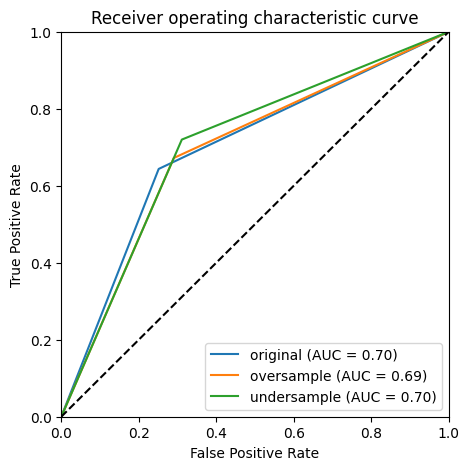

In [61]:
# 평가지표
evaluate_model(y_6_val, [xgb_orign_class_6_pred, xgb_ros_class_6_pred, xgb_rus_class_6_pred], ['original', 'oversample', 'undersample'])

Confusion matrix, without normalization
[[539 181]
 [201 363]]


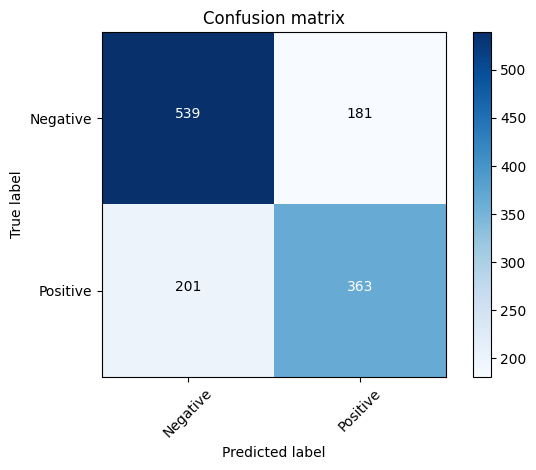

Confusion matrix, without normalization
[[511 209]
 [185 379]]


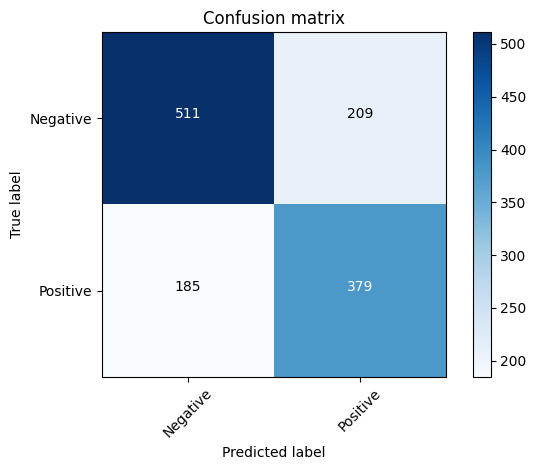

Confusion matrix, without normalization
[[496 224]
 [158 406]]


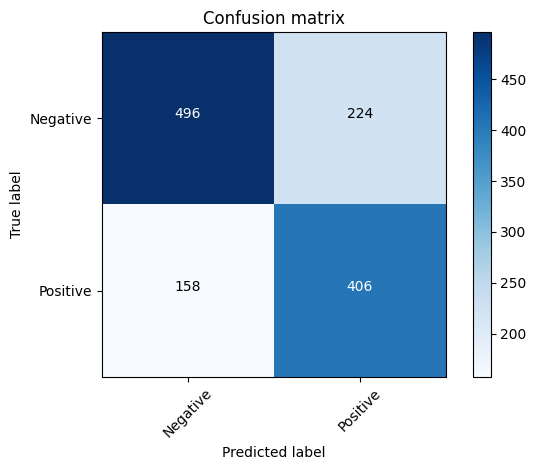

In [83]:
# 클래스의 이름을 정의
class_names = ['Negative', 'Positive']
cm_6_orign = confusion_matrix(y_6_val, xgb_orign_class_6_pred)
cm_6_ros = confusion_matrix(y_6_val, xgb_ros_class_6_pred)
cm_6_rus = confusion_matrix(y_6_val, xgb_rus_class_6_pred)

# 혼동행렬 그래프 출력
plt.figure()
plot_confusion_matrix(cm_6_orign, classes=class_names, title='Confusion matrix')
plt.show()

plt.figure()
plot_confusion_matrix(cm_6_ros, classes=class_names, title='Confusion matrix')
plt.show()

plt.figure()
plot_confusion_matrix(cm_6_rus, classes=class_names, title='Confusion matrix')
plt.show()

original Feature Importance
                 feature  importance
11               alcohol    0.098268
2       volatile acidity    0.097646
9                     pH    0.089211
6    free sulfur dioxide    0.086953
7   total sulfur dioxide    0.084097
8                density    0.084061
4         residual sugar    0.083825
10             sulphates    0.082517
3            citric acid    0.080717
5              chlorides    0.078979
1          fixed acidity    0.076968
0                   type    0.056758
oversample Feature Importance
                 feature  importance
11               alcohol    0.109303
0                   type    0.105897
2       volatile acidity    0.099723
6    free sulfur dioxide    0.083656
7   total sulfur dioxide    0.078849
8                density    0.078360
10             sulphates    0.077372
4         residual sugar    0.077097
5              chlorides    0.074398
3            citric acid    0.072774
9                     pH    0.072387
1          fixed 

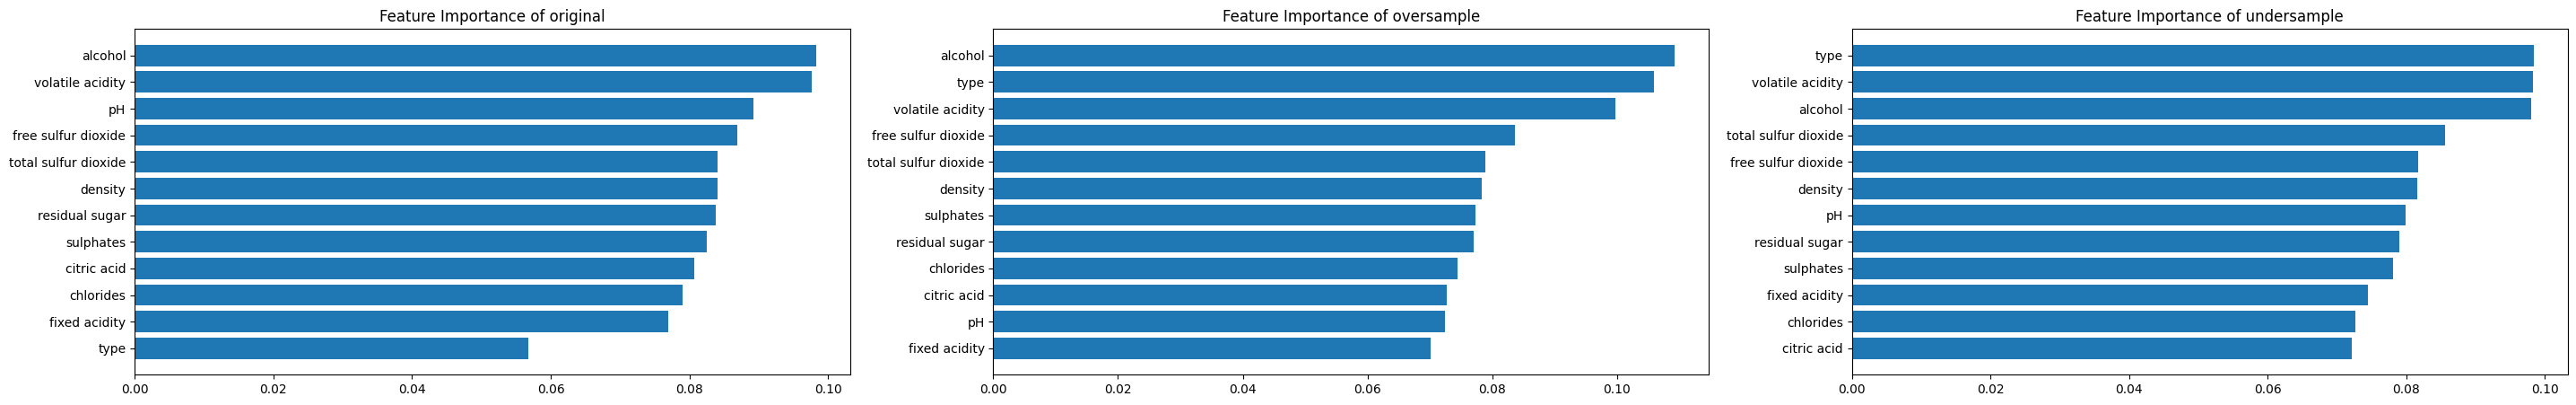

In [63]:
# feature importance
feature_importance(X_6_val, y_6_val, [model_xgb_orign_class_6, model_xgb_ros_class_6, model_xgb_rus_class_6], ['original', 'oversample', 'undersample'])

### 4.3.1 y_7

In [40]:
# y_7
# -------------------------------------------------------------------------------------------------------------------
# orign data result:  {'subsample': 0.9, 'reg_lambda': 0.037649358067924674, 'reg_alpha': 0.001747528400007683, 'n_estimators': 400, 'max_depth': 11, 'learning_rate': 0.2009233002565048, 'gamma': 0.5, 'colsample_bytree': 0.6}
# orign data result:  0.5305452841604459
# -------------------------------------------------------------------------------------------------------------------
# ros data result:  {'subsample': 0.8, 'reg_lambda': 0.002009233002565048, 'reg_alpha': 0.004037017258596553, 'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.023101297000831605, 'gamma': 0.2, 'colsample_bytree': 0.6}
# ros data result:  0.9015358862590954
# -------------------------------------------------------------------------------------------------------------------
# rus data result:  {'subsample': 0.9, 'reg_lambda': 0.30538555088334157, 'reg_alpha': 0.014174741629268055, 'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.0021544346900318843, 'gamma': 0.1, 'colsample_bytree': 0.8}
# rus data result:  0.7888391775982132
# -------------------------------------------------------------------------------------------------------------------

In [64]:
# 하이퍼파라미터 설정
model_xgb_orign_class_7 = XGBClassifier(subsample=0.9, reg_lambda=0.037649358067924674, reg_alpha=0.001747528400007683, n_estimators=400, max_depth=11, learning_rate=0.2009233002565048, gamma=0.5, colsample_bytree=0.6)
model_xgb_ros_class_7 = XGBClassifier(subsample=0.8, reg_lambda=0.002009233002565048, reg_alpha=0.004037017258596553, n_estimators=300, max_depth=11, learning_rate=0.023101297000831605, gamma=0.2, colsample_bytree=0.6)
model_xgb_rus_class_7 = XGBClassifier(subsample=0.9, reg_lambda=0.30538555088334157, reg_alpha=0.014174741629268055, n_estimators=100, max_depth=11, learning_rate=0.0021544346900318843, gamma=0.1, colsample_bytree=0.8)

# 모델 학습
model_xgb_orign_class_7.fit(X_7_train, y_7_train)
model_xgb_ros_class_7.fit(X_7_train_ros, y_7_train_ros)
model_xgb_rus_class_7.fit(X_7_train_rus, y_7_train_rus)

# 모델 예측
xgb_orign_class_7_pred = model_xgb_orign_class_7.predict(X_7_val)
xgb_ros_class_7_pred = model_xgb_ros_class_7.predict(X_7_val)
xgb_rus_class_7_pred = model_xgb_rus_class_7.predict(X_7_val)
print(xgb_orign_class_7_pred)
print(xgb_ros_class_7_pred)
print(xgb_rus_class_7_pred)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 1 0]


                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
   original     |   0.8653   |   0.6897   |   0.4386   |   0.5362   |   0.6980  
  oversample    |   0.8653   |   0.6382   |   0.5570   |   0.5948   |   0.7444  
  undersample   |   0.7313   |   0.3779   |   0.7939   |   0.5120   |   0.7558  
--------------------------------------------------------------------------------


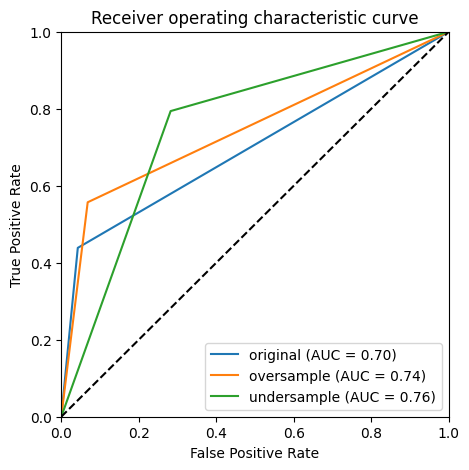

In [65]:
# 평가지표
evaluate_model(y_7_val, [xgb_orign_class_7_pred, xgb_ros_class_7_pred, xgb_rus_class_7_pred], ['original', 'oversample', 'undersample'])

Confusion matrix, without normalization
[[1011   45]
 [ 128  100]]


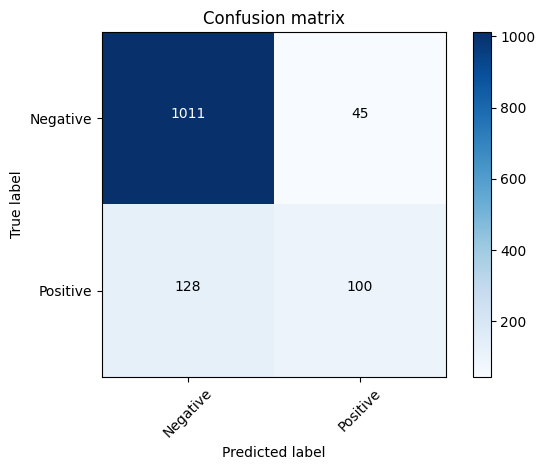

Confusion matrix, without normalization
[[984  72]
 [101 127]]


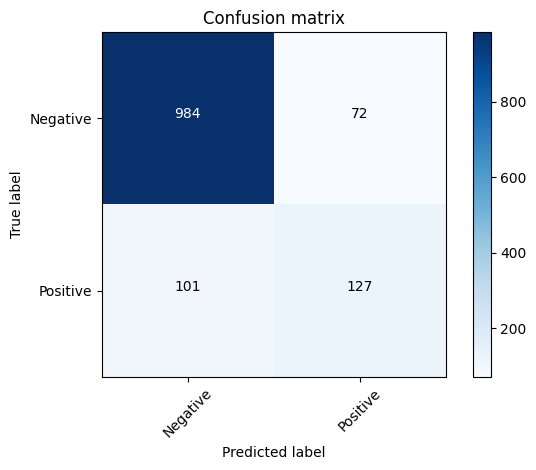

Confusion matrix, without normalization
[[758 298]
 [ 47 181]]


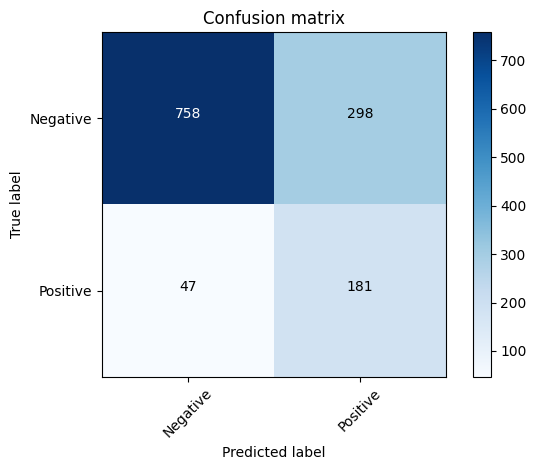

In [84]:
# 클래스의 이름을 정의
class_names = ['Negative', 'Positive']
cm_7_orign = confusion_matrix(y_7_val, xgb_orign_class_7_pred)
cm_7_ros = confusion_matrix(y_7_val, xgb_ros_class_7_pred)
cm_7_rus = confusion_matrix(y_7_val, xgb_rus_class_7_pred)

# 혼동행렬 그래프 출력
plt.figure()
plot_confusion_matrix(cm_7_orign, classes=class_names, title='Confusion matrix')
plt.show()

plt.figure()
plot_confusion_matrix(cm_7_ros, classes=class_names, title='Confusion matrix')
plt.show()

plt.figure()
plot_confusion_matrix(cm_7_rus, classes=class_names, title='Confusion matrix')
plt.show()

original Feature Importance
                 feature  importance
0                   type    0.202481
11               alcohol    0.135978
8                density    0.075001
10             sulphates    0.073300
4         residual sugar    0.071792
2       volatile acidity    0.070861
5              chlorides    0.065902
6    free sulfur dioxide    0.065415
7   total sulfur dioxide    0.065288
9                     pH    0.064029
3            citric acid    0.057646
1          fixed acidity    0.052307
oversample Feature Importance
                 feature  importance
11               alcohol    0.175361
0                   type    0.108595
2       volatile acidity    0.082719
5              chlorides    0.080007
4         residual sugar    0.078822
3            citric acid    0.077768
1          fixed acidity    0.074030
7   total sulfur dioxide    0.068881
8                density    0.068566
6    free sulfur dioxide    0.067722
10             sulphates    0.062379
9                

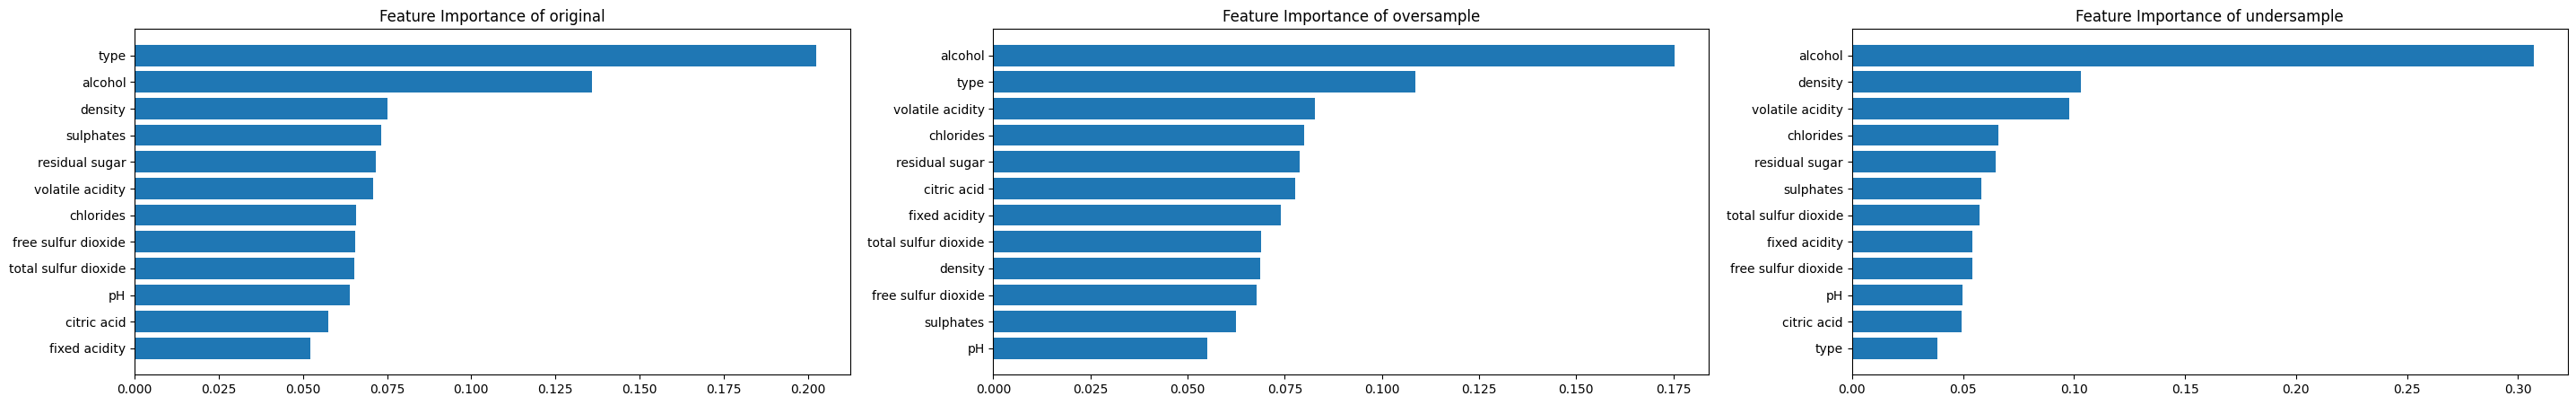

In [67]:
# feature importance
feature_importance(X_7_val, y_7_val, [model_xgb_orign_class_7, model_xgb_ros_class_7, model_xgb_rus_class_7], ['original', 'oversample', 'undersample'])

### 4.3.1 y_8

In [68]:
# y_8
# ------------------------------------------------------------------------------------------------------------------
# orign data result:  {'subsample': 0.6, 'reg_lambda': 0.02848035868435802, 'reg_alpha': 0.04328761281083059, 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.5336699231206312, 'gamma': 0, 'colsample_bytree': 0.6}
# orign data result:  0.35196551724137926
# -------------------------------------------------------------------------------------------------------------------
# ros data result:  {'subsample': 0.9, 'reg_lambda': 0.06579332246575682, 'reg_alpha': 0.30538555088334157, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1747528400007685, 'gamma': 0.3, 'colsample_bytree': 0.7}
# ros data result:  0.9859929370452292
# -------------------------------------------------------------------------------------------------------------------
# rus data result:  {'subsample': 0.9, 'reg_lambda': 46.41588833612782, 'reg_alpha': 0.3511191734215131, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2848035868435802, 'gamma': 0.5, 'colsample_bytree': 0.9}
# rus data result:  0.8373020354386813
# -------------------------------------------------------------------------------------------------------------------

In [69]:
# 하이퍼파라미터 설정
model_xgb_orign_class_8 = XGBClassifier(subsample=0.6, reg_lambda=0.02848035868435802, reg_alpha=0.04328761281083059, n_estimators=50, max_depth=11, learning_rate=0.5336699231206312, gamma=0, colsample_bytree=0.6)
model_xgb_ros_class_8 = XGBClassifier(subsample=0.9, reg_lambda=0.06579332246575682, reg_alpha=0.30538555088334157, n_estimators=200, max_depth=5, learning_rate=0.1747528400007685, gamma=0.3, colsample_bytree=0.7)
model_xgb_rus_class_8 = XGBClassifier(subsample=0.9, reg_lambda=46.41588833612782, reg_alpha=0.3511191734215131, n_estimators=100, max_depth=3, learning_rate=0.2848035868435802, gamma=0.5, colsample_bytree=0.9)

# 모델 학습
model_xgb_orign_class_8.fit(X_8_train, y_8_train)
model_xgb_ros_class_8.fit(X_8_train_ros, y_8_train_ros)
model_xgb_rus_class_8.fit(X_8_train_rus, y_8_train_rus)

# 모델 예측
xgb_orign_class_8_pred = model_xgb_orign_class_8.predict(X_8_val)
xgb_ros_class_8_pred = model_xgb_ros_class_8.predict(X_8_val)
xgb_rus_class_8_pred = model_xgb_rus_class_8.predict(X_8_val)
print(xgb_orign_class_8_pred)
print(xgb_ros_class_8_pred)
print(xgb_rus_class_8_pred)


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
   original     |   0.9751   |   0.7727   |   0.3864   |   0.5152   |   0.6912  
  oversample    |   0.9650   |   0.4839   |   0.3409   |   0.4000   |   0.6640  
  undersample   |   0.7399   |   0.0904   |   0.7273   |   0.1608   |   0.7338  
--------------------------------------------------------------------------------


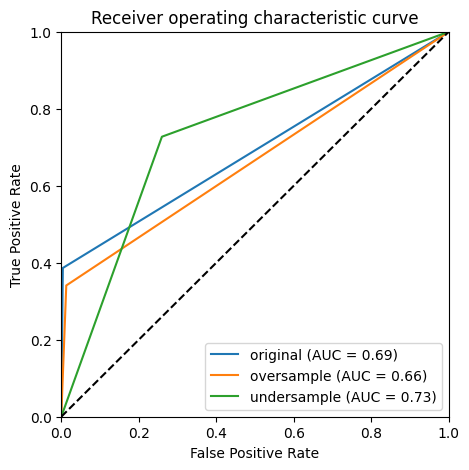

In [70]:
# 평가지표
evaluate_model(y_8_val, [xgb_orign_class_8_pred, xgb_ros_class_8_pred, xgb_rus_class_8_pred], ['original', 'oversample', 'undersample'])

Confusion matrix, without normalization
[[1235    5]
 [  27   17]]


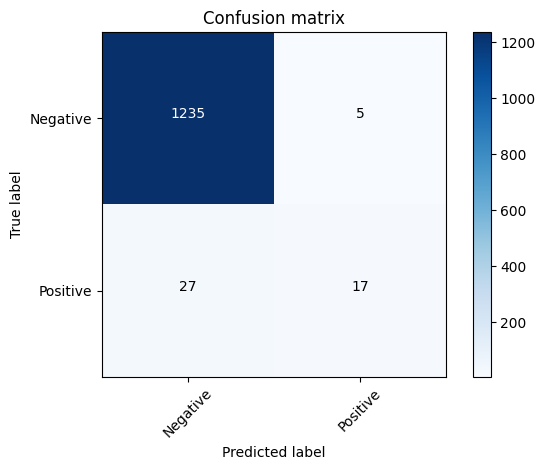

Confusion matrix, without normalization
[[1224   16]
 [  29   15]]


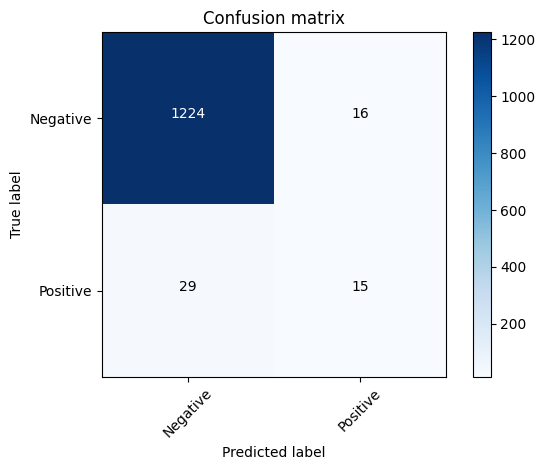

Confusion matrix, without normalization
[[918 322]
 [ 12  32]]


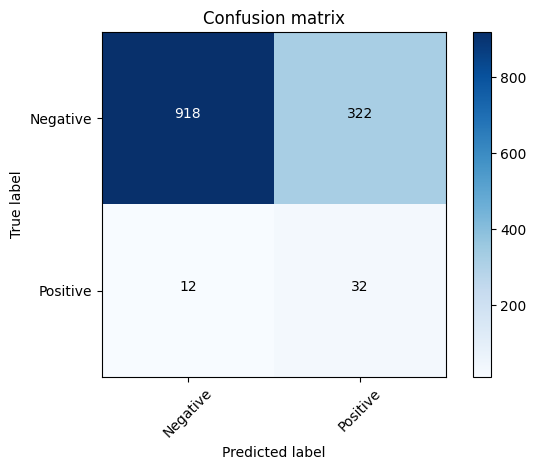

In [71]:
# 클래스의 이름을 정의
class_names = ['Negative', 'Positive']
cm_8_orign = confusion_matrix(y_8_val, xgb_orign_class_8_pred)
cm_8_ros = confusion_matrix(y_8_val, xgb_ros_class_8_pred)
cm_8_rus = confusion_matrix(y_8_val, xgb_rus_class_8_pred)

# 혼동행렬 그래프 출력
plt.figure()
plot_confusion_matrix(cm_8_orign, classes=class_names, title='Confusion matrix')
plt.show()

plt.figure()
plot_confusion_matrix(cm_8_ros, classes=class_names, title='Confusion matrix')
plt.show()

plt.figure()
plot_confusion_matrix(cm_8_rus, classes=class_names, title='Confusion matrix')
plt.show()

original Feature Importance
                 feature  importance
11               alcohol    0.102298
5              chlorides    0.099642
9                     pH    0.098165
10             sulphates    0.097188
2       volatile acidity    0.092090
4         residual sugar    0.091843
8                density    0.089567
7   total sulfur dioxide    0.088994
6    free sulfur dioxide    0.086376
3            citric acid    0.077468
1          fixed acidity    0.076368
0                   type    0.000000
oversample Feature Importance
                 feature  importance
0                   type    0.243434
11               alcohol    0.158951
8                density    0.093398
2       volatile acidity    0.087122
4         residual sugar    0.065698
6    free sulfur dioxide    0.063376
7   total sulfur dioxide    0.054109
9                     pH    0.052626
5              chlorides    0.049907
3            citric acid    0.047728
1          fixed acidity    0.043010
10             su

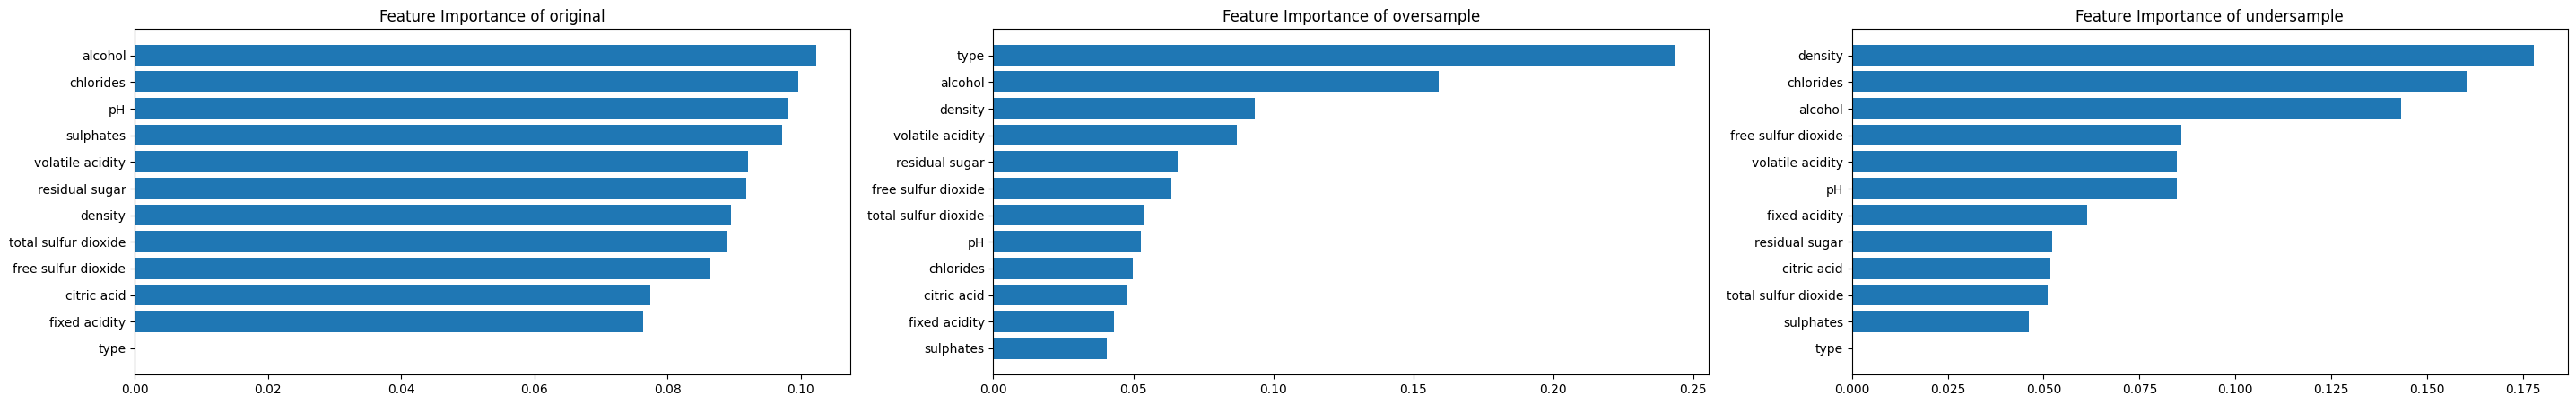

In [72]:
# feature importance
feature_importance(X_8_val, y_8_val, [model_xgb_orign_class_8, model_xgb_ros_class_8, model_xgb_rus_class_8], ['original', 'oversample', 'undersample'])

# 5. Model Selection 및 trained model 저장

In [ ]:
# Accuracy가 높은 모델을 선출
# class_4 : model_xgb_ros_class_4
# class_5 : model_xgb_orign_class_5
# class_6 : model_xgb_rus_class_6
# class_7 : model_xgb_ros_class_7
# class_8 : model_xgb_orign_class_8

In [73]:
import joblib

joblib.dump(model_xgb_ros_class_4, './model_xgb_over_class_4.joblib')
joblib.dump(model_xgb_orign_class_5, './model_xgb_orign_class_5.joblib')
joblib.dump(model_xgb_rus_class_6, './model_xgb_under_class_6.joblib')
joblib.dump(model_xgb_ros_class_7, './model_xgb_over_class_7.joblib')
joblib.dump(model_xgb_orign_class_8, './model_xgb_orign_class_8.joblib')

['./model_xgb_orign_class_8.joblib']

In [78]:
import csv

# 결과를 저장할 데이터
vmatrix = [
    ["", "Accuracy", "Precision", "Recall", "F1-score", "AUC"],
    ["original", 0.9751, 0.7727, 0.3864, 0.5152, 0.6912],
    ["oversample", 0.9650, 0.4839, 0.3409, 0.4000, 0.6640],
    ["undersample", 0.7399, 0.0904, 0.7273, 0.1608, 0.7338],
]

# CSV 파일로 저장
with open("class_8_index.csv", "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(vmatrix)